# Valence Navigator

Goal: To estimate the valence of substitutional defects in crystals.

In [1]:
# fixing autocomplete
%config Completer.use_jedi = False
# better quality plots in notebook
%config InlineBackend.figure_format='retina'
# cell timings
%load_ext autotime
import pandas as pd
from decimal import Decimal
import pickle, os, mplcursors
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from crystal_secrets import *
mpdr = MPDataRetrieval(api_key=secrets['materials_project_api_key'])

In [2]:
import numpy as np

## Analyis of the Materials Project static database

There is a static version of the Materials Project data from 2018.

https://figshare.com/articles/dataset/Materials_Project_Data/7227749

In [17]:
from matminer.datasets import load_dataset

time: 1.54 ms (started: 2021-08-30 12:08:54 -04:00)


In [3]:
import pymatgen

In [4]:
mp_df = pd.read_csv('/Users/juan/Downloads/mp_all.csv')

In [5]:
structures = list(map(eval, mp_df['structure']))

In [7]:
structures[0]

{'@module': 'pymatgen.core.structure',
 '@class': 'Structure',
 'lattice': {'matrix': [[2.91977105, 1e-08, -1.62074865],
   [-0.89966798, 2.77770801, -1.62074865],
   [-0.01236211, -0.01699831, 3.41808222]],
  'a': 3.339444440456365,
  'b': 3.339444631900979,
  'c': 3.418146841050957,
  'alpha': 119.2412321385702,
  'beta': 119.24123388395572,
  'gamma': 89.99999130876336,
  'volume': 27.560695310731177},
 'sites': [{'species': [{'element': 'In', 'occu': 1}],
   'abc': [0.0, 0.0, 0.0],
   'xyz': [0.0, 0.0, 0.0],
   'label': 'In',
   'properties': {'magmom': 0.0}}]}

In [6]:
len(structures)

83989

In [86]:
def parse_chemical_formula(struc):
    sites = struc['sites']
    species = [s['species'][0]['element'] for s in sites]
    species_counts = {elem: species.count(elem) for elem in set(species)}
    return species_counts

time: 9.92 ms (started: 2021-08-30 14:19:06 -04:00)


In [91]:
parsed_structures = list(map(parse_chemical_formula, structures))

time: 4.57 s (started: 2021-08-30 14:26:48 -04:00)


In [94]:
mp_df['parsed_structure'] = parsed_structures
mp_df['num_elements'] = list(map(len,parsed_structures))

time: 117 ms (started: 2021-08-30 14:28:04 -04:00)


In [98]:
binary_compounds = mp_df[mp_df['num_elements'] == 2]

time: 1.92 s (started: 2021-08-30 14:30:11 -04:00)


In [122]:
def binary_electroneg(parse_struct):
    elements = list(parse_struct.keys())
    electronegs = list(map(lambda x: pymatgen.core.Element(x).X, elements))
    return max(electronegs) - min(electronegs)

time: 1.21 ms (started: 2021-08-30 14:34:13 -04:00)


In [123]:
list(list(binary_compounds['parsed_structure'])[0].keys())

['Hg', 'Ce']

time: 14.2 ms (started: 2021-08-30 14:34:14 -04:00)


In [130]:
binary_compounds['avg_electronegativity'] = list(map(binary_electroneg, list(binary_compounds['parsed_structure'])))

time: 94.5 ms (started: 2021-08-30 14:37:20 -04:00)


/Users/juan/opt/anaconda3/envs/qdef/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [131]:
binary_ionic_compounds = binary_compounds[binary_compounds['avg_electronegativity']>2]

time: 39.6 ms (started: 2021-08-30 14:37:53 -04:00)


In [142]:
struc = binary_ionic_compounds['parsed_structure'].iloc[0]

time: 9.13 ms (started: 2021-08-30 14:41:38 -04:00)


In [149]:
oxides = binary_ionic_compounds[binary_ionic_compounds['parsed_structure'].apply(lambda x: 'O' in x.keys())]

time: 4.6 ms (started: 2021-08-30 14:44:13 -04:00)


In [169]:
['O','H'].remove('O')

TypeError: 'NoneType' object is not iterable

time: 35.4 ms (started: 2021-08-30 14:48:01 -04:00)


In [180]:
partner_ionizations = []
for oxide in oxides.iterrows():
    n_oxygen = oxide[1]['parsed_structure']['O']
    elements = list(oxide[1]['parsed_structure'].keys())
    elements.remove('O')
    partner_element = elements[0]
    n_partner = oxide[1]['parsed_structure'][partner_element]
    i1 = 2*n_oxygen/n_partner
    if int(i1) != i1:
        i1 = None
    else:
        i1 = int(i1)
    partner_ionizations.append(i1)

time: 30.9 ms (started: 2021-08-30 14:56:06 -04:00)


In [182]:
oxides['cation_charge'] = partner_ionizations

time: 6.47 ms (started: 2021-08-30 14:56:27 -04:00)


/Users/juan/opt/anaconda3/envs/qdef/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [220]:
matchers = {1: ['Sc','Co'],
            2: ['Ti','Ni'],
            3: ['V','Cu'],
            4: ['Cr','Zn'],
            5: ['Mn'],
            6: ['Fe']}
for i in range(1,7):
    for elemens in matchers[i]:
        print('')
        kernel = '\ce{%s}^{%d+}\!\!:\!\!' % (elemens,i)
        things = list(set(oxides[oxides['cation_charge'] == i]['pretty_formula']))
        things = list(map(lambda x: kernel+'\ce{'+x+'}', things))
        print(', '.join(things))


\ce{Sc}^{1+}\!\!:\!\!\ce{Cs2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{K2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Na2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Zr2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Rb2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Li2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Sm2O}

\ce{Co}^{1+}\!\!:\!\!\ce{Cs2O}, \ce{Co}^{1+}\!\!:\!\!\ce{K2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Na2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Zr2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Rb2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Li2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Sm2O}

\ce{Ti}^{2+}\!\!:\!\!\ce{CaO}, \ce{Ti}^{2+}\!\!:\!\!\ce{UO}, \ce{Ti}^{2+}\!\!:\!\!\ce{Li2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{GdO}, \ce{Ti}^{2+}\!\!:\!\!\ce{NdO}, \ce{Ti}^{2+}\!\!:\!\!\ce{ZrO}, \ce{Ti}^{2+}\!\!:\!\!\ce{YbO}, \ce{Ti}^{2+}\!\!:\!\!\ce{K2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{ScO}, \ce{Ti}^{2+}\!\!:\!\!\ce{PrO}, \ce{Ti}^{2+}\!\!:\!\!\ce{Rb2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{SrO}, \ce{Ti}^{2+}\!\!:\!\!\ce{CeO}, \ce{Ti}^{2+}\!\!:\!\!\ce{HoO}, \ce{Ti}^{2+}\!\!:\!\!\ce{SmO}, \ce{Ti}^{2+}\!\!:\!\!\ce{PuO}, \ce{Ti}^{2+}\!\!:\!\!\ce{EuO}, \ce{Ti}^{2+}\!\!:\!\!\

In [171]:
elements

['O', 'Pr']

time: 2.57 ms (started: 2021-08-30 14:48:21 -04:00)


In [163]:
oxide[1]['num_elements']

2

time: 2.62 ms (started: 2021-08-30 14:46:29 -04:00)


In [32]:
mp_df['structure']

NoneType

time: 3.27 ms (started: 2021-08-30 13:51:37 -04:00)


In [8]:
mp_df = load_dataset('mp_all_20181018')

In [18]:
another_df = load_dataset('mp_all_20181018')

time: 12min 52s (started: 2021-08-30 12:11:17 -04:00)


In [20]:
adf = pd.read_pickle('/Users/juan/Google Drive/Zia Lab/Codebase/qdef/data/mp_2018.pkl')

time: 8min 30s (started: 2021-08-30 13:33:45 -04:00)


In [7]:
import json

In [ ]:
with open("/Users/juan/Downloads/mp_all.json", encoding="utf-8") as infile:
    mp_df = json.load(infile)

## Fun functions & Parsing

In [3]:
def some_in_list(l1,l2):
    return sum([L1 in l2 for L1 in l1]) > 0

In [4]:
def spinless(abundance):
    '''This function returns a list of atoms with 
    at least the provided spinless natural abundance'''
    spin_less_and_plenty = all_spinless[all_spinless['nat_spinless_abundance']>=abundance]
    return spin_less_and_plenty.index.tolist()
def spinfull(abundance):
    spineless = spinless(abundance)
    return [s for s in all_at_symbols if s not in spineless]

In [5]:
all_at_symbols = ['Ac','Ag','Al','Am','Ar','As','At','Au','B','Ba','Be','Bh',
                  'Bi','Bk','Br','C','Ca','Cd','Ce','Cf','Cl','Cm','Cn','Co',
                  'Cr','Cs','Cu','Db','Ds','Dy','Er','Es','Eu','F','Fe','Fl',
                  'Fm','Fr','Ga','Gd','Ge','H','He','Hf','Hg','Ho','Hs','I',
                  'In','Ir','K','Kr','La','Li','Lr','Lu','Lv','Mc','Md','Mg',
                  'Mn','Mo','Mt','N','Na','Nb','Nd','Ne','Nh','Ni','No','Np',
                  'O','Og','Os','P','Pa','Pb','Pd','Pm','Po','Pr','Pt','Pu',
                  'Ra','Rb','Re','Rf','Rg','Rh','Rn','Ru','S','Sb','Sc','Se',
                  'Sg','Si','Sm','Sn','Sr','Ta','Tb','Tc','Te','Th','Ti','Tl',
                  'Tm','Ts','U','V','W','Xe','Y','Yb','Zn','Zr']
spindata = open('spinData.txt','r').read()
spindata = [l.strip().split() for l in spindata.split('\n') if '%' not in l]
allSpin = []
for spinDatum in spindata:
    spindict = {'atomic_number':int(spinDatum[0]),
               'nucleons':int(spinDatum[1]),
               'radioactive':spinDatum[2],
               'symbol':spinDatum[3],
               'name':spinDatum[4],
               'spin':Decimal(spinDatum[5]).as_integer_ratio(),
               'g_nuclear':float(spinDatum[6]),
               'nat_abundance':float(spinDatum[7])/100., 
               'e_quad_moment':float(spinDatum[8])}
    spindict['radioactive'] = (spindict['radioactive'] == '*')
    allSpin.append(spindict)
spinData = pd.DataFrame(allSpin)

In [6]:
# for each atomic number compute the natural abundance of spinless atoms
all_spinless = []
for at_number in list(set(spinData['atomic_number'])):
    this_group = spinData[spinData['atomic_number']==at_number]
    symb = list(this_group['symbol'])[0]
    name = list(this_group['name'])[0]
    this_group = this_group[this_group['spin'] == Decimal('0').as_integer_ratio()]
    this_ab = np.sum(this_group['nat_abundance'])

    this_dict = {'atomic_number': at_number,
                 'symbol': symb,
                 'name': name,
                 'nat_spinless_abundance': this_ab}
    all_spinless.append(this_dict)
all_spinless = pd.DataFrame(all_spinless)
all_spinless.set_index('symbol', inplace=True)

In [15]:
all_spinless.to_json('/Users/david/Google Drive/Zia Lab/Codebase/qdef/all_spinless.json')

In [ ]:
pd.read_json('/Users/david/Google Drive/Zia Lab/Codebase/qdef/all_spinless.json')

In [7]:
ferrenti = pickle.load(open('ferrenti.pkl','rb'))
ferrenti_df = pd.read_excel('/Users/david/Google Drive/Zia Lab/Log/Data/Ferrenti 2020.xlsx', usecols=range(18))
ferrenti_df = ferrenti_df[ferrenti_df['Ferrenti 2020'] > 0]
ferrenti_ids = [l for l in ferrenti_df['Materials ID'].to_list() if 'mp-' in l]

In [8]:
criteria = {'material_id':{'$in': ferrenti_ids}}
props = ['band_gap','cif','elements','pretty_formula',
         'density','nelements', 'structure','spacegroup',
        'e_above_hull','icsd_ids','formation_energy_per_atom']
ferrenti_gt = mpdr.get_dataframe(criteria=criteria, properties=props)

  0%|          | 0/537 [00:00<?, ?it/s]

In [10]:
ferrenti_gt.to_pickle('/Users/david/Google Drive/Zia Lab/Codebase/qdef/data/ferrenti_gt.pkl')

In [539]:
pkl_fname = os.path.join(data_dir,'ferrenti_gt.pkl')
pickle.dump(ferrenti_gt,open(pkl_fname,'wb'))

In [11]:
ferrenti_gtt = pd.read_pickle('/Users/david/Google Drive/Zia Lab/Codebase/qdef/data/ferrenti_gt.pkl')

## Queries

In [211]:
def crystal_sieve(sieve_parameters):
    if sieve_parameters['element_selection'][0] == 'natural':
        return crystal_sieve_natural(sieve_parameters)
    elif sieve_parameters['element_selection'][0] == 'manual':
        return crystal_sieve_manual(sieve_parameters)
    else:
        print("Invalid choice for element selection.")
        return None
def crystal_sieve_natural(sieve_parameters):
    spinless_abundance = sieve_parameters['element_selection'][1]
    min_gap, max_gap = sieve_parameters['bandgap_interval']
    num_ingredients = list(range(sieve_parameters['num_ingredients'][0],
                                 sieve_parameters['num_ingredients'][1]+1))
    ####################################################################
    print("Filtering for elements with a natural spinless isotopic abundance equal or greater than %.1f%%." % (100*spinless_abundance))
    sieve_parameters['allowed_elements'] = spinless(spinless_abundance)
    sieve_parameters['not_allowed_elements'] = spinfull(spinless_abundance)
    print("There are %d elements matching this criterion." % len(sieve_parameters['allowed_elements']))
    ####################################################################
    print("Searching the Materials Project...")
    criteria = {'band_gap':{'$gte':min_gap,'$lte':max_gap},
                'nelements': {'$in': num_ingredients},
                'elements':{'$in':sieve_parameters['allowed_elements'],
                            '$nin':sieve_parameters['not_allowed_elements']}}
    props = ['band_gap','cif','elements','pretty_formula',
             'density','nelements', 'structure','spacegroup',
            'e_above_hull','icsd_ids','formation_energy_per_atom']
    sieve_parameters['search_results'] = mpdr.get_dataframe(criteria=criteria,
                     properties=props)
    sieve_parameters['search_results']['polar'] = [s['point_group'] in polar_point_groups for s in sieve_parameters['search_results']['spacegroup']]
    sieve_parameters['search_results']['contains_unviable_elements'] = sieve_parameters['search_results']['elements'].apply(lambda x: some_in_list(x, sieve_parameters['unviable_elements']))
    return sieve_parameters
def crystal_sieve_manual(sieve_parameters):
    return "Hello manual."

In [347]:
sieve_parameters = {
    'element_selection': ('natural',0.50),
    'bandgap_interval': (0.5,6.25),
    'space_group_syms': ('auto'),
    'max_e_above_hull': 0.2,
    'num_ingredients': (1,5),
    'unviable_elements': ['Ce','Nd','Sm','Gd','Dy','Er','Yb','Th',
                          'U','Cd','Hg','He','Ne','Ar','Kr','Xe']
}
sieve_parameters = crystal_sieve(sieve_parameters)

Filtering for elements with a natural spinless isotopic abundance equal or greater than 50.0%.
There are 42 elements matching this criterion.
Searching the Materials Project...


  0%|          | 0/5380 [00:00<?, ?it/s]

In [348]:
data_dir = '/Users/david/Google Drive/Zia Lab/Log/Data'
pkl_fname = os.path.join(data_dir,'crystal_search-%d.pkl' % int(time.time()))
pickle.dump(sieve_parameters,open(pkl_fname,'wb'))
print(pkl_fname)

/Users/david/Google Drive/Zia Lab/Log/Data/crystal_search-1613093038.pkl


In [356]:
# apply additional filters
good_ones = (~sieve_parameters['search_results']['contains_unviable_elements']
            & ~sieve_parameters['search_results']['polar']
            & (sieve_parameters['search_results']['e_above_hull'] < sieve_parameters['max_e_above_hull'])
            & (sieve_parameters['search_results']['icsd_ids'].apply(lambda x: len(x) > 0))
            & ((sieve_parameters['search_results']['pretty_formula'] != 'SiO2') | (sieve_parameters['search_results'].index == 'mp-7000'))
            )
crystals_found = sieve_parameters['search_results'][good_ones]
crystals_found['in_ferrenti'] = crystals_found.index.map(lambda x: x in ferrenti_df['Materials ID'].to_list())
pretty_dictionary = crystals_found['pretty_formula'].to_dict()
pretty_formulas = crystals_found['pretty_formula'].to_list()
crystals_found['with_same_stoichiometry'] = crystals_found['pretty_formula'].apply(lambda x: [i for i in pretty_dictionary if pretty_dictionary[i] == x])
crystals_found['with_same_stoichiometry_len'] = crystals_found['with_same_stoichiometry'].apply(len)
crystals_found['spacegroup_symbol'] = crystals_found['spacegroup'].apply(lambda x: x['symbol'])
print('%d crystals found!'% len(crystals_found))
print('%d of them have different stoichiometry' % len(set((crystals_found['pretty_formula']))))
print('%d of them match with Ferrenti (which includes %d hosts)' % (sum(crystals_found['in_ferrenti']),len(ferrenti_df)))

1073 crystals found!
718 of them have different stoichiometry
522 of them match with Ferrenti (which includes 541 hosts)


In [433]:
# compute sets as a function of spinless abundance and bandgap estimate
spinlessness = np.linspace(0.4,1,50)
bgaps = np.linspace(2.0,5.5,50)
howmany = []
howmanyf = []
for ab in spinlessness:
    howmanyrow = []
    howmanyrowformulae = []
    for bgap in bgaps:
        accept = spinless(ab)
        found = (set(crystals_found[(crystals_found['elements'].apply(lambda x: len(x) == len(set(x).intersection(accept)))
                       & (crystals_found['band_gap']>bgap))]['pretty_formula']))
        howmanyrow.append(len(found))
        howmanyrowformulae.append(list(found))
    howmany.append(howmanyrow)
    howmanyf.append(howmanyrowformulae)
howmany = np.array(howmany)

In [495]:
def compounds(ab,bg):
    i = np.argmin(np.abs(spinlessness-ab))
    j = np.argmin(np.abs(bgaps-bg))
    r = sorted(howmanyf[i][j])
    if len(r) > 10:
        return ',\n'.join(r[:10]) + ('\n(%d more)...' % (len(r)-10))
    else:
        return ',\n'.join(r)

In [542]:
rhom = 4.09
mmass = 97.5
rhomol = rhom/mmass * 6.02e23 * 1e-21 # in particles per cubic nanometer
print('%.3f nm' % (1/(rhomol**(1/3))))

0.341 nm


<IPython.core.display.Javascript object>


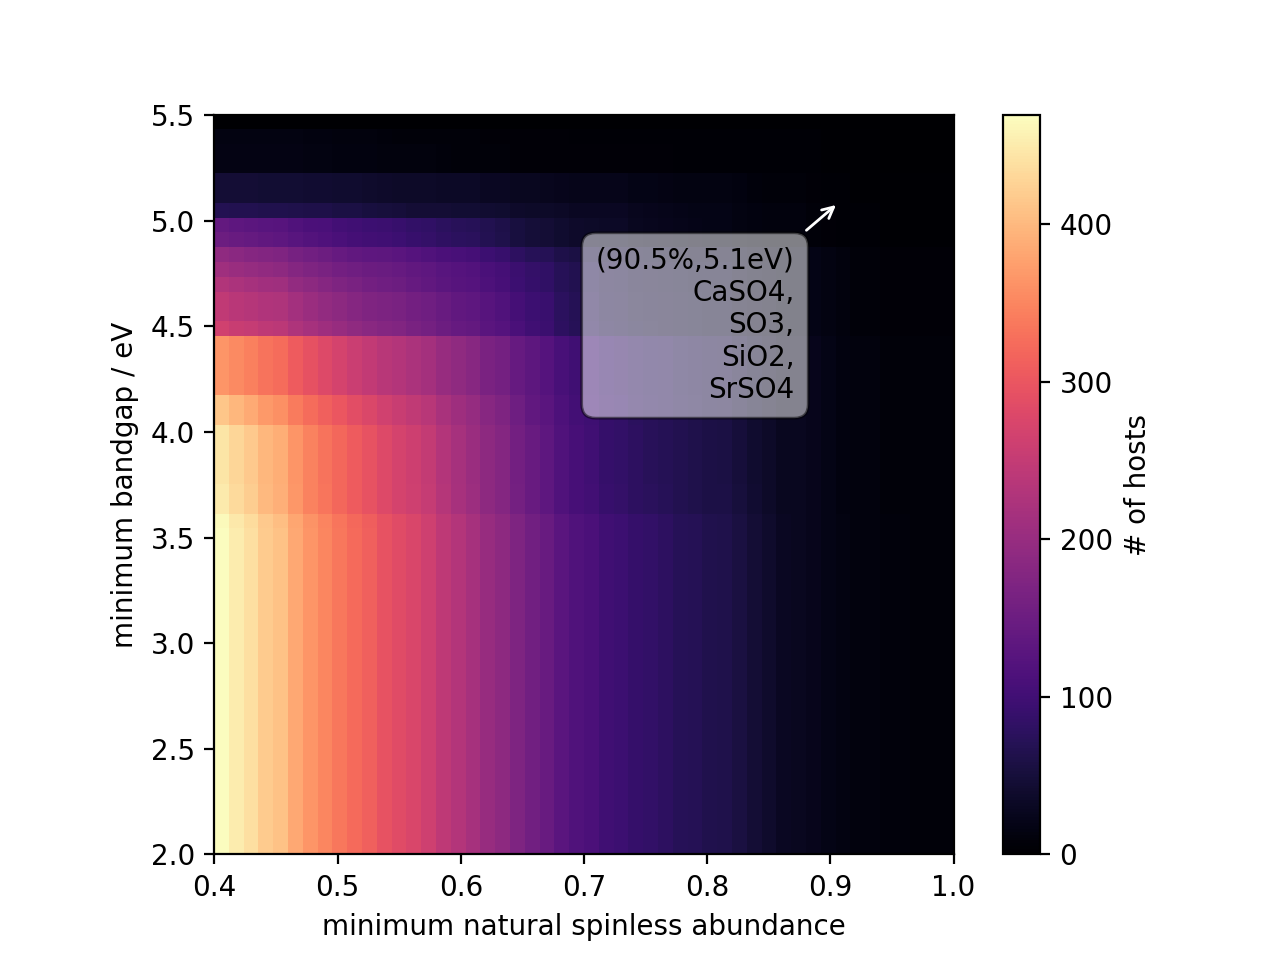

In [537]:
plt.figure()
hmap = plt.imshow(howmany,extent=[spinlessness[0],
                          spinlessness[-1],
                          bgaps[0],
                          bgaps[-1]], origin='lower',
          cmap='magma',
          aspect=1/((bgaps[-1]-bgaps[0])/(spinlessness[-1]-spinlessness[0])))
cbar = plt.colorbar()
cbar.set_label('# of hosts')
# mplcursors.cursor(hover=False,annotation_kwargs={'text':'y','xytext':(0.5,3)})
cursor = mplcursors.cursor(hover=False)
@cursor.connect("add")
def on_add(sel):
    ann = sel.annotation
    x, y = ann.xy
    anntxt = ('(%.1f%%,%.1feV)\n' % (x*100,y))+compounds(x,y)
    ann.arrowprops['ec'] = 'w'
    ann.set_backgroundcolor('white')
    ann.set_text(anntxt)
plt.xlabel('minimum natural spinless abundance')
plt.ylabel('minimum bandgap / eV')
plt.show()

# Old Stuff

In [2]:
mpdr = MPDataRetrieval(api_key='023o1DArkeOFQz8T')

In [ ]:
properties = ['density',]

In [15]:
df = mpdr.get_dataframe(criteria={"nelements": 1}, properties=['cif'])
print("There are {} entries on MP with 1 element".format(df['cif'].count()))

  0%|          | 0/716 [00:00<?, ?it/s]

There are 716 entries on MP with 1 element


In [19]:
print(df.iloc[0]['cif'])

# generated using pymatgen
data_Cs
_symmetry_space_group_name_H-M   'P 1'
_cell_length_a   5.29144986
_cell_length_b   5.29144986
_cell_length_c   5.29144986
_cell_angle_alpha   109.47122063
_cell_angle_beta   109.47122063
_cell_angle_gamma   109.47122063
_symmetry_Int_Tables_number   1
_chemical_formula_structural   Cs
_chemical_formula_sum   Cs1
_cell_volume   114.05180544
_cell_formula_units_Z   1
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Cs  Cs0  1  0.00000000  0.00000000  0.00000000  1



In [66]:
props = ['band_gap','cif','density','doi','e_above_hull','efermi','elements',
         'full_formula','final_energy','piezo','pretty_formula','pseudo_potential',
        'reduced_cell_formula','structure','spacegroup','tags','warnings']
results = mpdr.get_dataframe(criteria={"material_id": 'mp-1102227'},
         properties=props)

In [63]:
with open('tempcif.cif','w') as file:
    file.write(results['cif'][0])

In [65]:
!open tempcif.cif

In [67]:
props = ['band_gap','cif','pretty_formula',
        'structure','spacegroup']
results = mpdr.get_dataframe(criteria={"material_id": 'mp-1102227'},
         properties=props)

In [68]:
results

,band_gap,cif,pretty_formula,structure,spacegroup
material_id,,,,,
mp-1102227,6.4314,# generated using pymatgen\ndata_CO2\n_symmetr...,CO2,"[[5.01249416 0.05681684 5.42401875] C, [0.0568...","{'symprec': 0.1, 'source': 'spglib', 'symbol':..."


# More Elaborate Queries with mongoDB syntax

https://docs.mongodb.com/v2.6/reference/operator/query/

In [106]:
min_bandgap, max_bandgap = 5, 6
good_atoms = ["Ca","C","O"]
bad_atoms = ["Rb","Si"]
criteria = {'band_gap':{'$gte':min_bandgap,'$lte':max_bandgap},
            'elements':{'$in':good_atoms,'$nin':bad_atoms}}
props = ['band_gap','cif','pretty_formula','density','nelements',
        'structure','spacegroup']
results = mpdr.get_dataframe(criteria=criteria,
         properties=props)

  0%|          | 0/1546 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


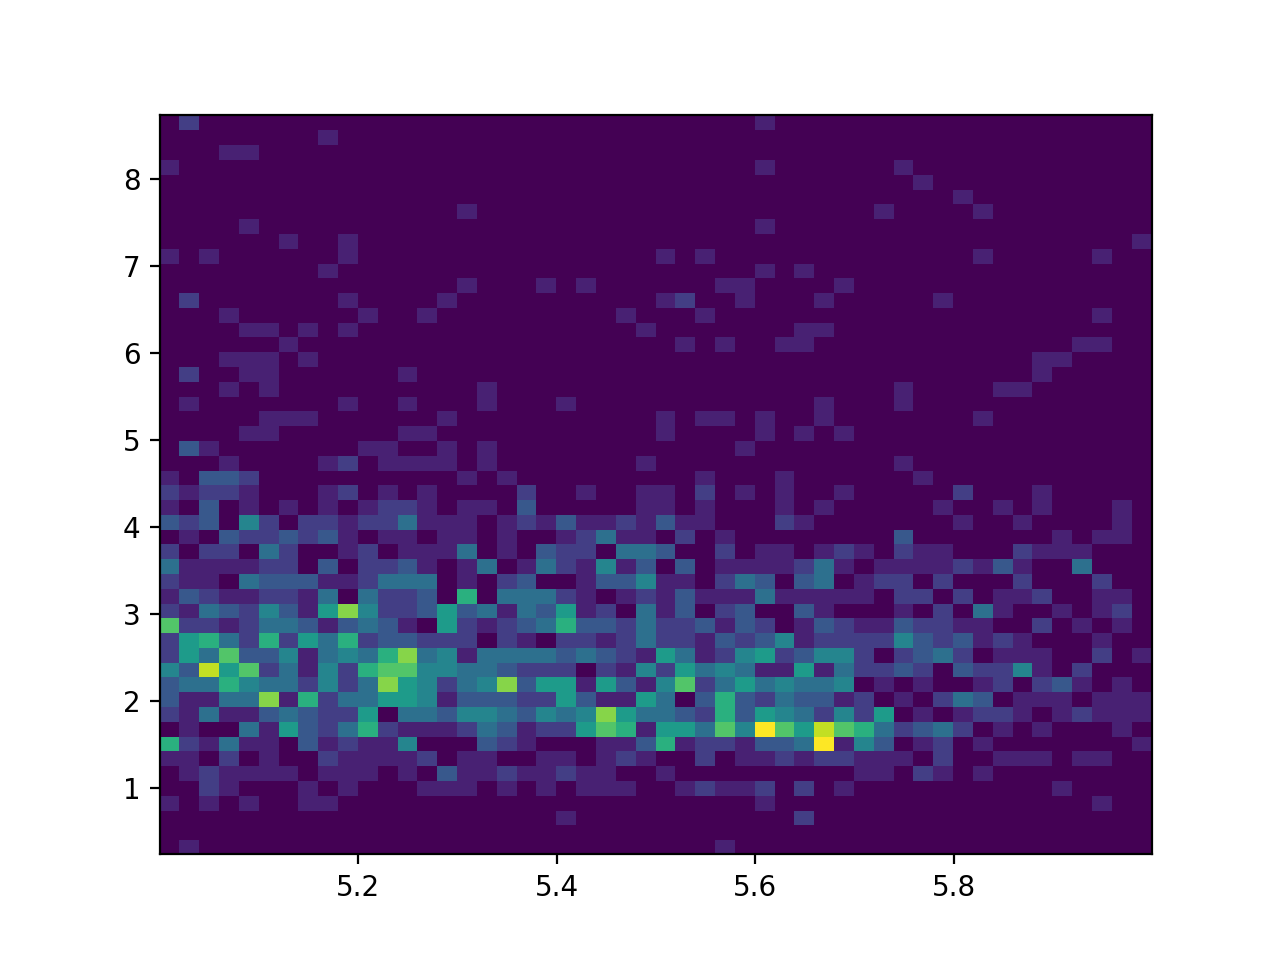

In [103]:
plt.figure()
plt.hist2d(results['band_gap'],results['density'],bins=50)
plt.show()

<IPython.core.display.Javascript object>


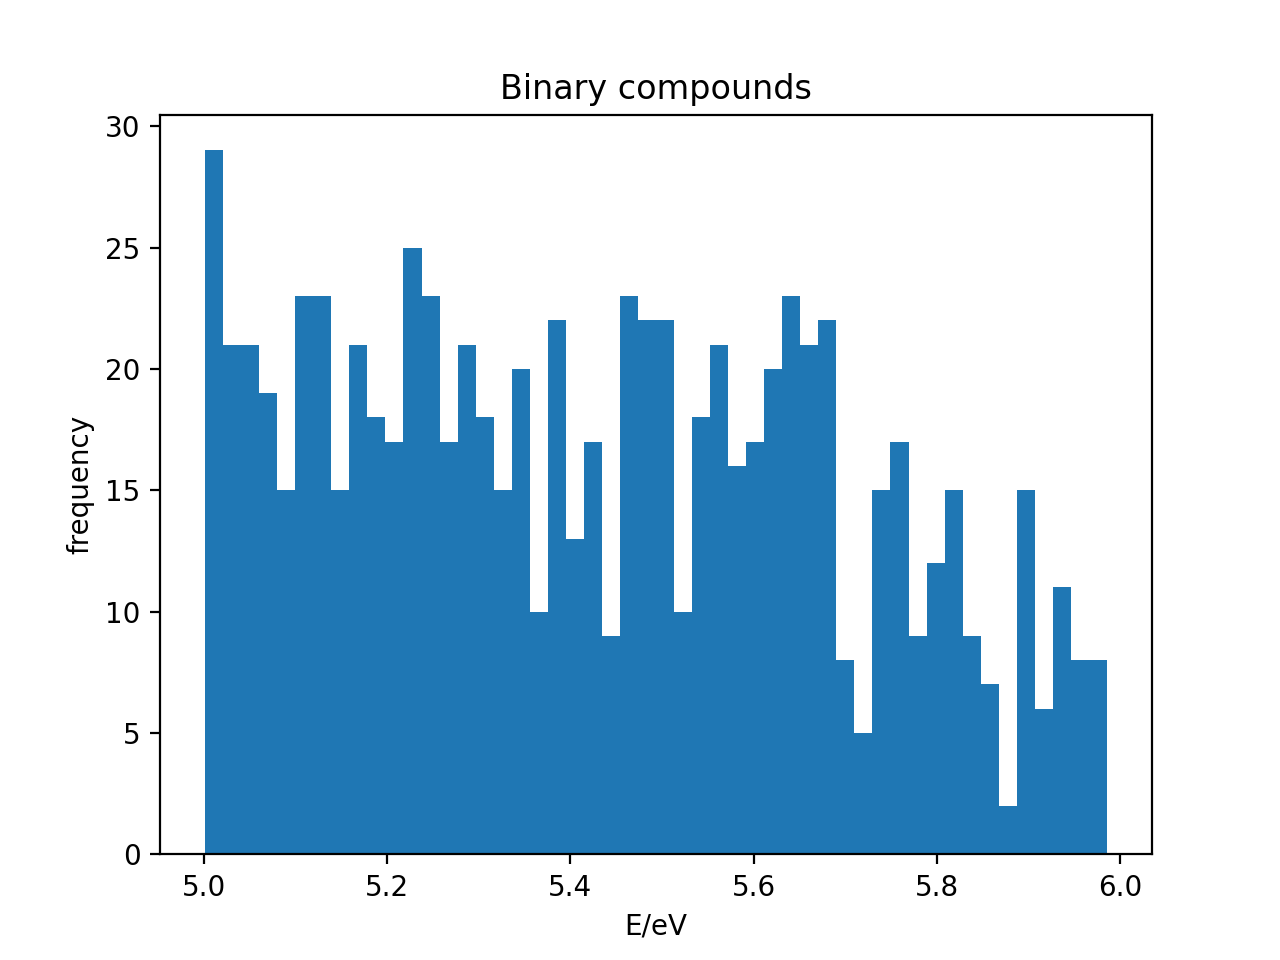

In [97]:
plt.figure()
plt.hist(results['band_gap'][results['nelements']==3],bins=50)
plt.xlabel('E/eV')
plt.ylabel('frequency')
plt.title('Binary compounds')
plt.show()

<IPython.core.display.Javascript object>


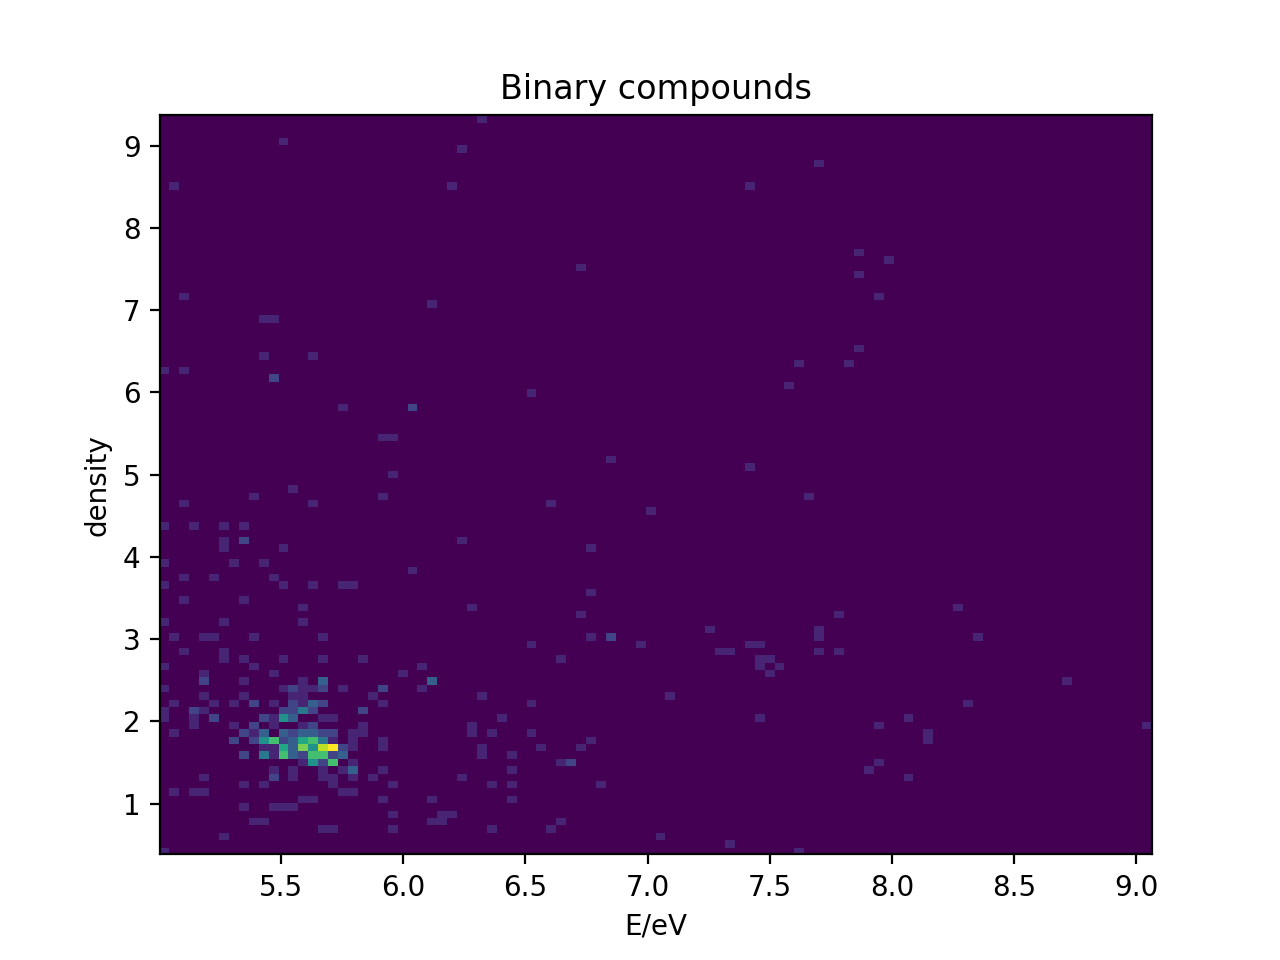

In [86]:
plt.figure()
plt.hist2d(results['band_gap'], results['density'], bins=100)
plt.xlabel('E/eV')
plt.ylabel('density')
plt.title('Binary compounds')
plt.show()